In [1]:
# global imports
from probe_gen.paths import data

# Generate and save perplexities

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from probe_gen.config import MODELS

# Load model and tokenizer
model_name = "llama_3b"
tokenizer = AutoTokenizer.from_pretrained(MODELS[model_name])
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
# If no pad token is set, reuse the EOS token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from get_activations.utils import load_jsonl_data

human_list, assistant_list, full_list = load_jsonl_data(data.refusal / "on_policy_balanced_5k.jsonl")

In [ ]:
from probe_gen.analysis import calculate_response_perplexities_sequentially

# TODO: Test the batched version of the function below that is already implemented. (Seems to require a lot of memory).
#       This one does the job but is a little slow.
perplexities = calculate_response_perplexities_sequentially(model, tokenizer, human_list, assistant_list, verbose=True)

In [ ]:
from probe_gen.analysis import save_perplexities

save_perplexities(perplexities, model_name, 'refusal_5k_on')

# Load and visualize perplexities

In [ ]:
from probe_gen.analysis import load_perplexities

perplexities_on = load_perplexities('llama_3b', 'refusal_5k_on')
perplexities_on_temp_1 = load_perplexities('llama_3b', 'refusal_5k_on_temp_1')
perplexities_on_temp_2 = load_perplexities('llama_3b', 'refusal_5k_on_temp_2')
perplexities_on_prompted = load_perplexities('llama_3b', 'refusal_5k_on_prompted')
perplexities_off = load_perplexities('llama_3b', 'refusal_5k_off_other_model')

This is a hacky fix for the fact that some responses are empty strings, and therefore return NaNs in perplexities. Ideally we filter for this during dataset generation!

In [ ]:
# TODO: Filter out empty responses in dataset generation pipeline instead of here

import numpy as np

def filter_out_nans(data):
    arr = np.array(data)
    arr = arr[np.isfinite(arr)]
    if len(arr) != len(data):
        print(f"Had to reduce data from length {len(data)} to {len(arr)} to filter out NaNs.")
    return arr

perplexities_on = filter_out_nans(perplexities_on)
perplexities_on_temp_1 = filter_out_nans(perplexities_on_temp_1)
perplexities_on_temp_2 = filter_out_nans(perplexities_on_temp_2)
perplexities_on_prompted = filter_out_nans(perplexities_on_prompted)
perplexities_off = filter_out_nans(perplexities_off)

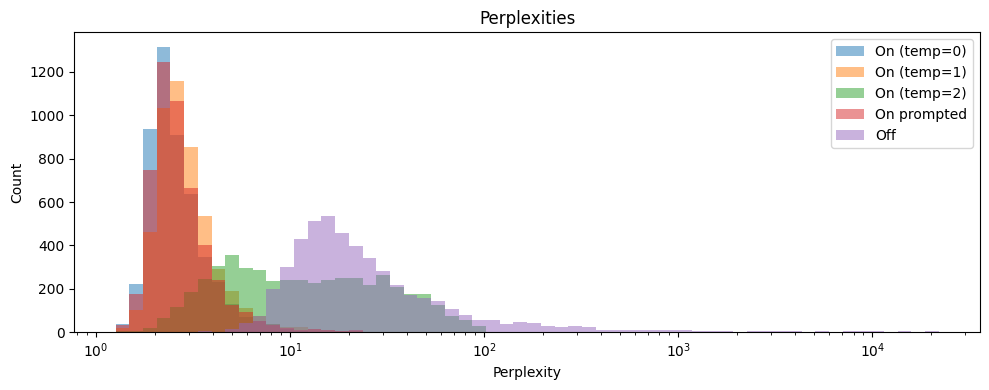

In [5]:
from probe_gen.analysis import plot_perplexities

plot_perplexities(
    [perplexities_on, perplexities_on_temp_1, perplexities_on_temp_2, perplexities_on_prompted, perplexities_off], 
    ['On (temp=0)', 'On (temp=1)', 'On (temp=2)', 'On prompted', 'Off'], 
    remove_outliers=True, 
    num_bins=60
)